# Predicting car prices

## 1: Importing and preparing datasets

### 1.1 - Importing packages

In [288]:
# Import packages
import pandas as pd
import glob
import os
import missingno as msno
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import math
from sklearn.compose import *
from sklearn.pipeline import *
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.linear_model import *
import joblib
from scipy import stats
import seaborn as sns
import warnings
from sklearn.linear_model import SGDRegressor
warnings.filterwarnings('ignore')
from sklearn.feature_selection import *
from sklearn.svm import SVR
import statsmodels.api as sm

### 1.2 - Loading in data

In [289]:
# Get list of CSVs in folder
files = glob.glob(r"E:\Python\Jupyter Files\Cars\essential_data/*.csv")

In [290]:
# Create empty lists to populate with the dataframes and their file names
file_names = []
dfs = []

# Loop over all files in the files list
for file in files:
    
    # Get list of all file names in folder
    base_name = os.path.basename(file)
    file_name = os.path.splitext(base_name)[0]
    file_names.append(file_name)
    
    # Load all dataframes in folder
    csv = pd.read_csv(file)
    dfs.append(csv)

In [291]:
# Create a list of dfs which now have a field for their make included
dfs2 = []

# Iterate over the dataframes appending a column for the make to each one
for i, df in enumerate(dfs):
    data = pd.DataFrame(df)
    data['make'] = file_names[i]
    dfs2.append(data)

In [292]:
# Concatenate all the dataframes together into one dataframe
df = pd.concat(dfs2)
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make,tax(£)
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,NaN
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,NaN
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,NaN
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,NaN
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw,NaN
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw,NaN
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw,NaN
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw,NaN


### 1.3 - Dropping unneeded columns

In [293]:
# Drop 'tax(£)' column as unsure of its meaning and all nulls - note: 'tax' field denotes road tax cost
df = df.drop(['tax(£)'], axis=1)

In [294]:
# Create car age column as more important factor than raw manufacturing year
df['carAge'] = 2020 - df['year']

# Drop manufacturing year
df = df.drop(['year'], axis=1)

In [295]:
# Get general description of the data
df.describe()

,price,mileage,tax,mpg,engineSize,carAge
count,99187.000000,99187.000000,94327.000000,99187.000000,99187.000000,99187.000000
mean,16805.347656,23058.914213,120.256183,55.166825,1.663280,2.912277
std,9866.773417,21148.523721,63.404805,16.138522,0.557646,2.123934
min,450.000000,1.000000,0.000000,0.300000,0.000000,-40.000000
25%,9999.000000,7425.000000,125.000000,47.100000,1.200000,1.000000
50%,14495.000000,17460.000000,145.000000,54.300000,1.600000,3.000000
75%,20870.000000,32339.000000,145.000000,62.800000,2.000000,4.000000
max,159999.000000,323000.000000,580.000000,470.800000,6.600000,50.000000


In [296]:
# Filter out incorrect data and electric cars
df = df[df['engineSize'] > 0]
df = df[df['carAge'] > -1]
df = df[df['fuelType'] != 'Electric']

In [297]:
# Reset index as current one is incorrect
df = df.reset_index(drop=True)

### 1.4 - Changing data types

In [298]:
# Check data types
df.dtypes

model            object
price             int64
transmission     object
mileage           int64
fuelType         object
tax             float64
mpg             float64
engineSize      float64
make             object
carAge            int64
dtype: object

In [299]:
# Change data types
df['model'] = df.model.astype('category')
df['transmission'] = df.transmission.astype('category')
df['fuelType'] = df.fuelType.astype('category')
df['make'] = df.make.astype('category')
df.dtypes

model           category
price              int64
transmission    category
mileage            int64
fuelType        category
tax              float64
mpg              float64
engineSize       float64
make            category
carAge             int64
dtype: object

### 1.5 - Identifying nulls

<AxesSubplot:>

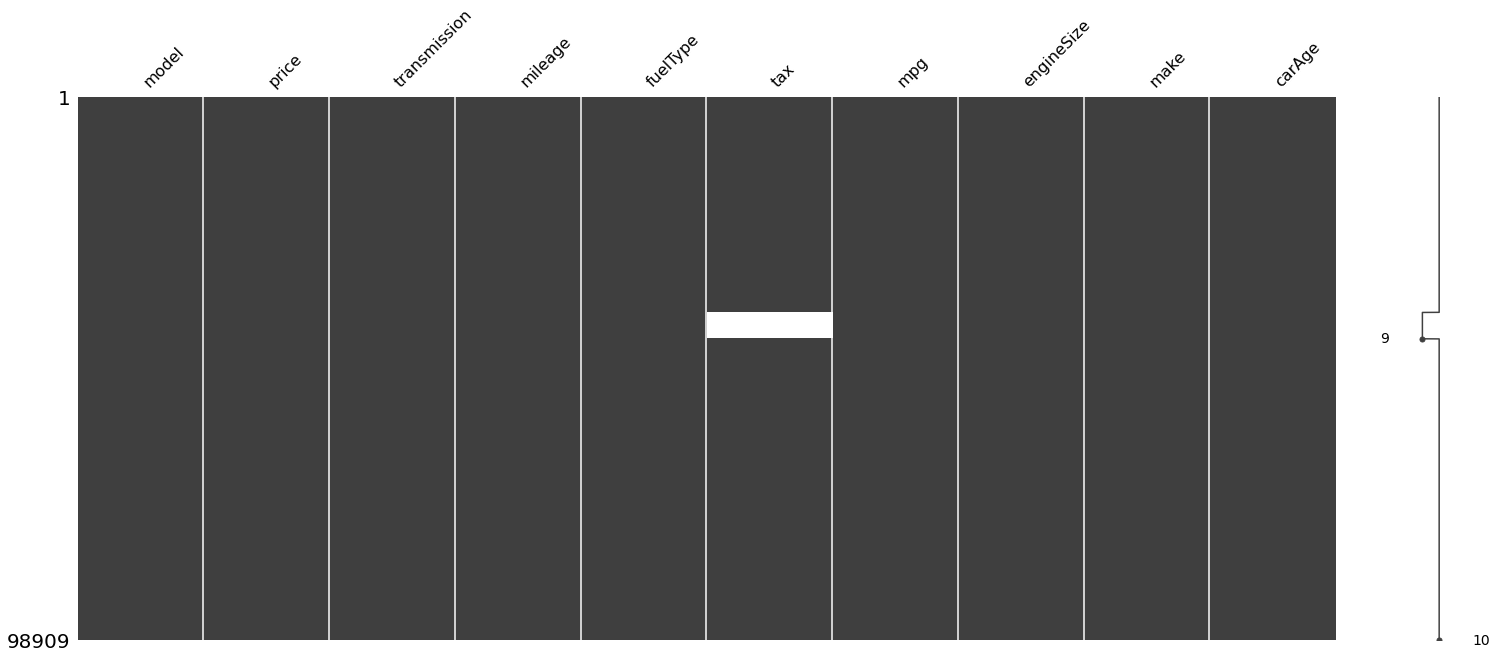

In [300]:
# Get nulls matrix to find nulls
msno.matrix(df)

In [301]:
# Drop rows containing nulls
df = df.dropna()

## 2: Investigating the data

### 2.1 - Defining categorical, numerical and label fields and filtering based on z-score

In [302]:
# Define categorical, numerical and label fields
categorical = ['model', 'transmission', 'fuelType', 'make']
numerical = ['mileage', 'tax', 'mpg', 'engineSize', 'carAge']
label = ['price']

In [303]:
# Remove rows with a z score greater than 6 and assign to new dataframe, df2
# z-score of 6 used to filter out extreme outliers whilst keeping vast majority of the data
z_thresh = 6
z = stats.zscore(df[numerical+label].copy())
df2 = df[(z < z_thresh).all(axis=1)]
df2

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,make,carAge
0,A1,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,3
1,A6,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,4
2,A1,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,4
3,A4,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,3
4,A3,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,1
...,...,...,...,...,...,...,...,...,...,...
98904,Eos,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw,8
98905,Fox,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw,12
98906,Fox,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw,11
98907,Fox,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw,14


### 2.2 - Visualising the data

#### 2.2.1 - Numerical data

<Figure size 432x288 with 0 Axes>

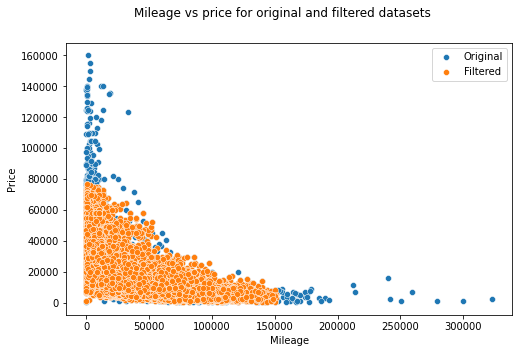

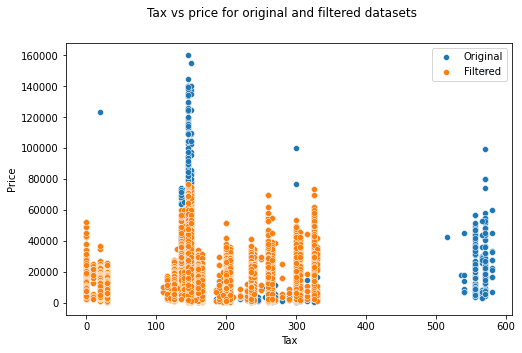

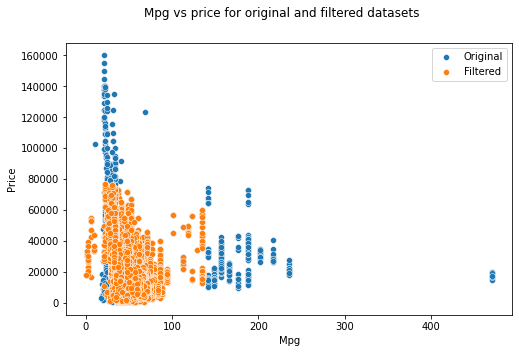

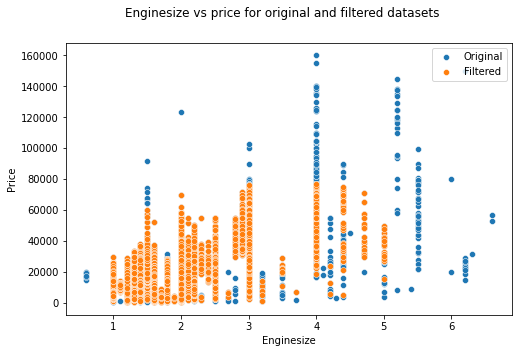

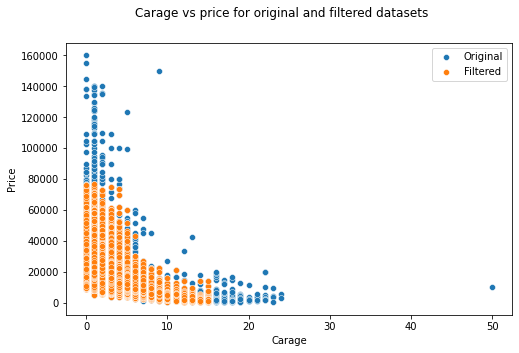

In [304]:
# Show graphs of all numerical column against price for the original and filtered data
for i, col in enumerate(numerical):
    plt.figure(i)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.scatterplot(df[col], df["price"], label='Original')
    sns.scatterplot(df2[col], df2["price"], label='Filtered')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Price')
    plt.legend(loc='upper right')
    plt.suptitle('{} vs price for original and filtered datasets'.format(col.capitalize()))

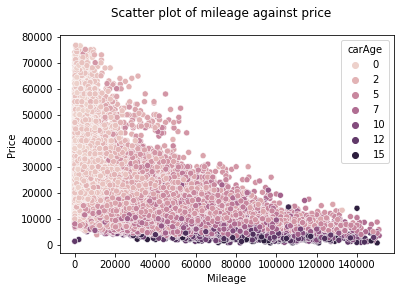

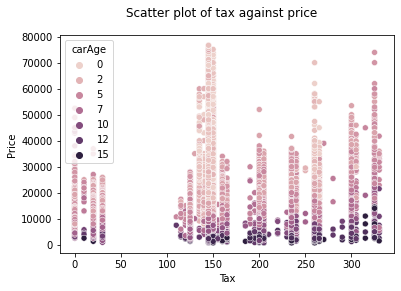

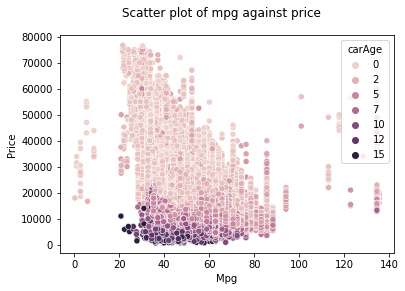

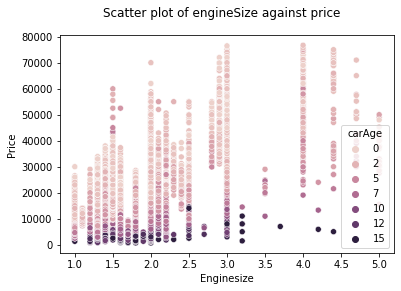

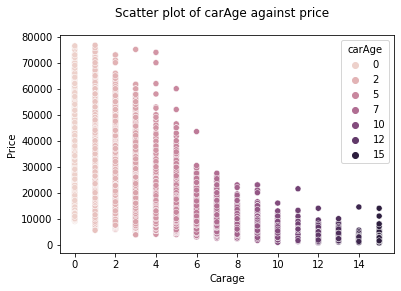

In [305]:
# Plot numerical variables against price with varying car age
for i, col in enumerate(numerical):
    plt.figure(i)
    sns.scatterplot(df2[col], df2["price"], hue = df2["carAge"])
    plt.ylabel('Price')
    plt.xlabel(col.capitalize())
    plt.suptitle('Scatter plot of {} against price'.format(col))

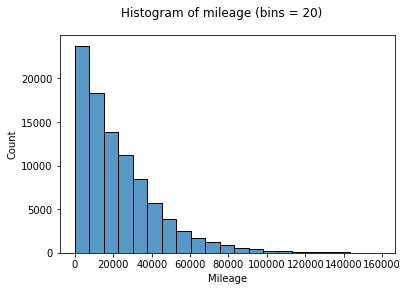

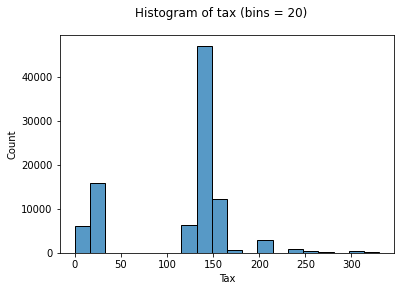

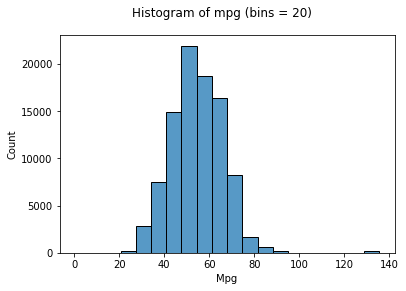

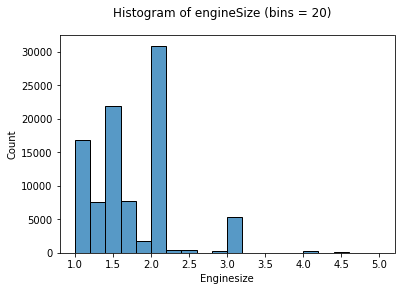

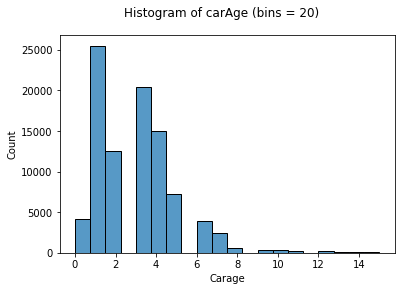

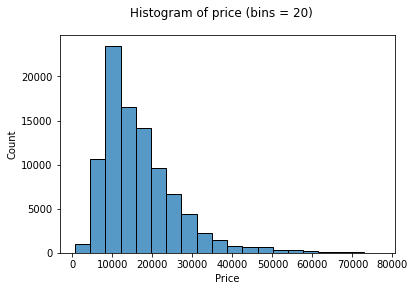

In [306]:
# Plot histogram of numerical variables
for i, col in enumerate(numerical+label):
    plt.figure(i)
    bins=20
    sns.histplot(df2[col], binwidth=(max(df2[col])-min(df2[col]))/bins)
    plt.xlabel(col.capitalize())
    plt.suptitle('Histogram of {} (bins = {})'.format(col, bins))

#### 2.2.2 - Categorical data

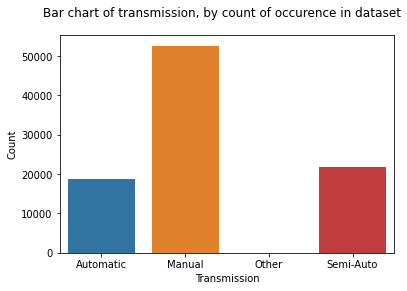

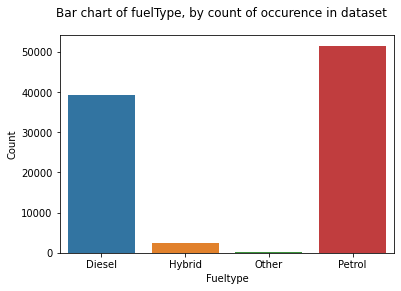

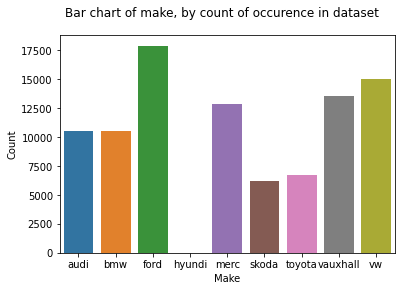

In [307]:
# Print bar charts of all categorical columns to show how common they are
for i, col in enumerate([cat for cat in categorical if cat != 'model']):
    plt.figure(i)
    sns.countplot(df2[col])
    plt.ylabel('Count')
    plt.xlabel(col.capitalize())
    plt.suptitle('Bar chart of {}, by count of occurence in dataset'.format(col))

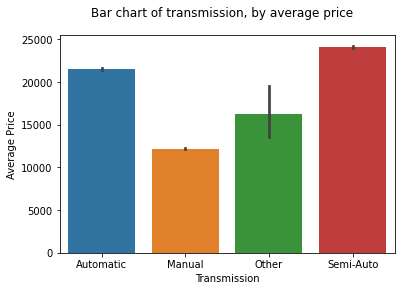

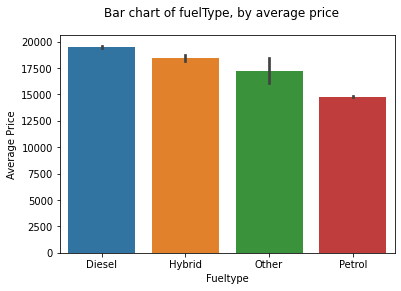

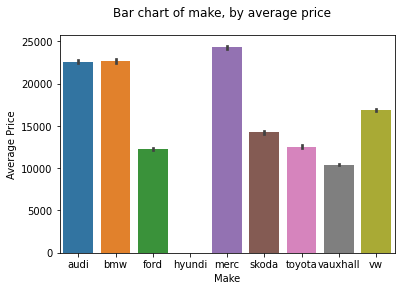

In [308]:
# Show bar charts of each categorical variable by average price
for i, col in enumerate([cat for cat in categorical if cat != 'model']):
    plt.figure(i)
    sns.barplot(x = df2[col], y = df2["price"])
    plt.ylabel('Average Price')
    plt.xlabel(col.capitalize())
    plt.suptitle('Bar chart of {}, by average price'.format(col))

#### 2.2.3 - Pair plot and heatmap

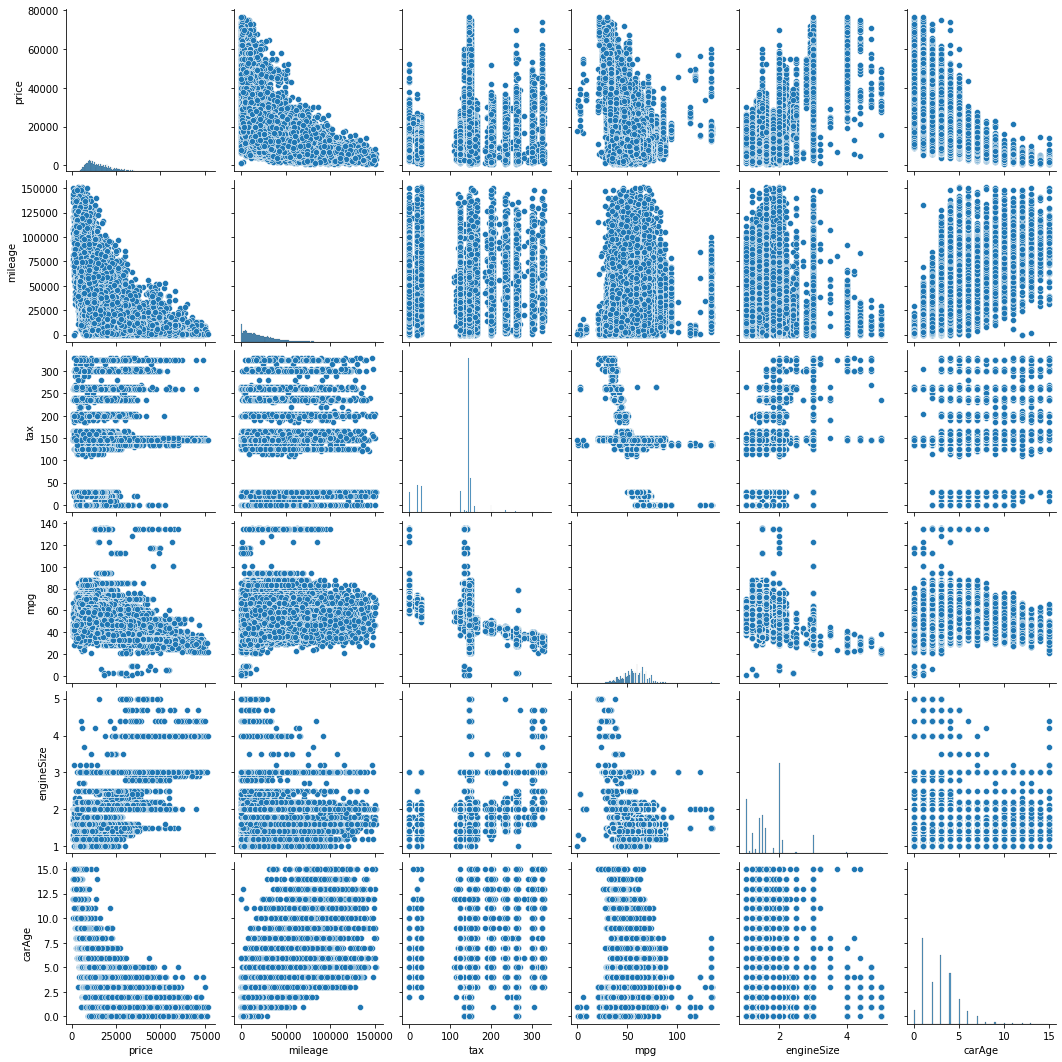

In [309]:
# Create pairplot of all numerical data
sns.pairplot(df2)

<AxesSubplot:>

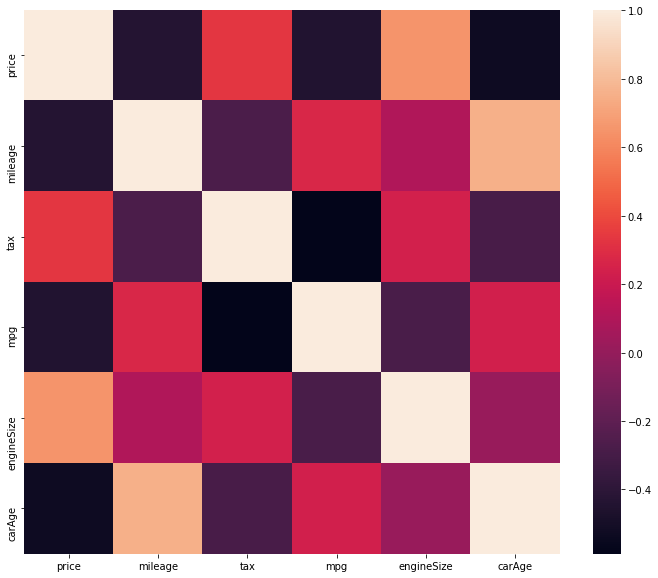

In [310]:
# Create heat map of all numerical data to show correlation
plt.figure(figsize=(12,10))
sns.heatmap(df2.corr())

## 3: Preparing the dataset

### 3.1 - Encoding and scaling the dataset

In [311]:
# One hot encode the categorical fields
df_expanded = pd.get_dummies(df2)
df_expanded

,price,mileage,tax,mpg,engineSize,carAge,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,...,fuelType_Petrol,make_audi,make_bmw,make_ford,make_hyundi,make_merc,make_skoda,make_toyota,make_vauxhall,make_vw
0,12500,15735,150.0,55.4,1.4,3,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,16500,36203,20.0,64.2,2.0,4,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,11000,29946,30.0,55.4,1.4,4,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,16800,25952,145.0,67.3,2.0,3,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,17300,1998,145.0,49.6,1.0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98904,5990,74000,125.0,58.9,2.0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98905,1799,88102,145.0,46.3,1.2,12,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
98906,1590,70000,200.0,42.0,1.4,11,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
98907,1250,82704,150.0,46.3,1.2,14,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [312]:
# Scale dataset
scaler = MinMaxScaler()
df_expanded_scaled = pd.DataFrame(scaler.fit_transform(df_expanded), columns=df_expanded.columns)
df_expanded_scaled

,price,mileage,tax,mpg,engineSize,carAge,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,...,fuelType_Petrol,make_audi,make_bmw,make_ford,make_hyundi,make_merc,make_skoda,make_toyota,make_vauxhall,make_vw
0,0.155543,0.104199,0.454545,0.407544,0.10,0.200000,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.208158,0.239750,0.060606,0.472633,0.25,0.266667,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.135812,0.198313,0.090909,0.407544,0.10,0.266667,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.212104,0.171862,0.439394,0.495562,0.25,0.200000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.218681,0.013225,0.439394,0.364645,0.00,0.066667,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93280,0.069912,0.490063,0.378788,0.433432,0.25,0.533333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93281,0.014785,0.583454,0.439394,0.340237,0.05,0.800000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93282,0.012036,0.463573,0.606061,0.308432,0.10,0.733333,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93283,0.007563,0.547706,0.454545,0.340237,0.05,0.933333,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3.2 - Splitting dataset into features and labels, test and train

In [313]:
# Split data into feature columns and label
features = df_expanded_scaled.drop(['price'], axis=1)
label = pd.DataFrame(df_expanded_scaled['price'])

In [314]:
# Split data into train and test samples
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

### 3.3 - Reducing dimensionality

#### 3.3.1 - SelectKBest

([<matplotlib.axis.XTick at 0x234736f5a08>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

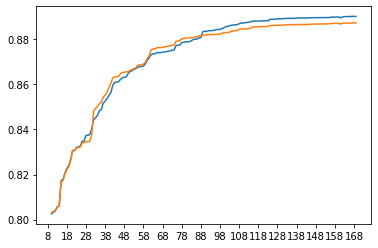

In [315]:
# Get list of column headers
column_names = df_expanded_scaled.drop(columns = ['price']).columns

# Create list of results for plotting on graph
no_of_features = []
r_squared_train = []
r_squared_test = []

# Try k number of best features
for k in range(10, 170):
    selector = SelectKBest(f_regression, k = k)
    x_train_transformed = selector.fit_transform(x_train, y_train)
    x_test_transformed = selector.transform(x_test)
    regressor = LinearRegression()
    regressor.fit(x_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(x_train_transformed, y_train))
    r_squared_test.append(regressor.score(x_test_transformed, y_test))

# Plot results
sns.lineplot(x = no_of_features, y = r_squared_train, legend = 'full')
sns.lineplot(x = no_of_features, y = r_squared_test, legend = 'full')
plt.xticks(np.arange(8, 175, step=10))

In [316]:
# Curve stablises after ~130, so select 135
selector = SelectKBest(f_regression, k = 135)
x_train_reduced = selector.fit_transform(x_train, y_train)
x_test_reduced = selector.transform(x_test)

In [317]:
# Get column headers after fitting selector
mask = selector.get_support()
cn = x_train.columns[mask]
cn = list(cn)

In [318]:
# Convert np array into dataframe
x_train_reduced = pd.DataFrame(x_train_reduced)
x_train_reduced.columns = cn
x_train_reduced

,mileage,tax,mpg,engineSize,carAge,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,...,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,make_audi,make_bmw,make_ford,make_merc,make_skoda,make_toyota,make_vauxhall
0,0.301009,0.484848,0.384615,0.250,0.333333,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.346055,0.090909,0.451923,0.250,0.266667,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.034186,0.439394,0.352071,0.050,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.225677,0.378788,0.433432,0.250,0.266667,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.479612,0.060606,0.507396,0.250,0.266667,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74623,0.272883,0.378788,0.423817,0.250,0.266667,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
74624,0.110590,0.439394,0.432692,0.000,0.200000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
74625,0.136663,0.439394,0.451923,0.150,0.133333,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74626,0.003470,0.439394,0.300296,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
# Convert np array into dataframe
x_test_reduced = pd.DataFrame(x_test_reduced)
x_test_reduced.columns = cn
x_test_reduced

,mileage,tax,mpg,engineSize,carAge,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,...,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,make_audi,make_bmw,make_ford,make_merc,make_skoda,make_toyota,make_vauxhall
0,0.094954,0.606061,0.309911,0.100,0.266667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.205412,0.439394,0.415680,0.275,0.200000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.048769,0.439394,0.407544,0.000,0.200000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.054788,0.439394,0.335059,0.000,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.017841,0.439394,0.462278,0.250,0.066667,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18652,0.006616,0.439394,0.407544,0.250,0.066667,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18653,0.078173,0.606061,0.296598,0.100,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18654,0.226405,0.621212,0.292160,0.250,0.200000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18655,0.048755,0.439394,0.462278,0.000,0.133333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 3.3.2 - Removing p-values > 0.05 

In [320]:
# Use statsmodels package to find p values
regressor = sm.OLS(y_train.values, x_train_reduced).fit()
print(regressor.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.922e+04
Date:                Mon, 12 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:15:11   Log-Likelihood:                      1.3212e+05
No. Observations:               74628   AIC:                                 -2.640e+05
Df Residuals:                   74493   BIC:                                 -2.627e+05
Df Model:                         135                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [321]:
# Get dataframe of columns with p-score greater than 0.1
p_thresh = 0.10
columns = regressor.pvalues[regressor.pvalues > p_thresh]
columns = pd.DataFrame(columns, index = None)
columns = columns.reset_index()
columns.columns = ['Columns', 'P-score']
columns

,Columns,P-score
0,model_ 7 Series,0.387004
1,model_ Agila,0.699653
2,model_ Beetle,0.786017
3,model_ CL Class,0.893281
4,model_ M2,0.478902
5,model_ M3,0.285935
6,model_ M4,0.266999
7,model_ Roomster,0.810957
8,model_ X2,0.144152
9,model_ X3,0.563945


In [322]:
# Remove columns with p-value greater than 0.1
for i in columns['Columns']:
    x_train_reduced = x_train_reduced.drop([i], axis=1)
    x_test_reduced = x_test_reduced.drop([i], axis=1)

## 4: Fitting a regression model

### 4.1 - Investigating different models

In [323]:
# Define function to fit regression model
def fit_regressor(regressor):
    regressor.fit(x_train_reduced, y_train)
    score = regressor.score(x_test_reduced, y_test)
    mse = mean_squared_error(regressor.predict(x_test_reduced), y_test)
    return regressor, score, mse

In [324]:
# Create list of regressors to try
regressors = [LinearRegression(), Ridge(), RandomForestRegressor(), GradientBoostingRegressor()]
df_scores = pd.DataFrame(columns=['Regressor', 'Score'])

# Try list of regressors and create dataframe of the results
for reg in regressors:
    regressor, score, mse = fit_regressor(reg)
    df_scores = df_scores.append({'Regressor': reg, 'Score': round(score,4)}, ignore_index=True)
    
df_scores.sort_values(by=['Score'], ascending=False)

,Regressor,Score
2,"(DecisionTreeRegressor(max_features='auto', ra...",0.9657
3,([DecisionTreeRegressor(criterion='friedman_ms...,0.9080
0,LinearRegression(),0.8836
1,Ridge(),0.8836
